<a href="https://colab.research.google.com/github/fariyanalam/Projects/blob/main/PHYS152_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Supersymmetric (SUSY) and Standard Model Particle Classification using Autoencoder + Classifier


**Introduction and Overview:**

The Large Hadron Collider (LHC) is a particle accelerator that allows for the collision of two high-energy particle beams which travel close to the speed of light. Since the introduction of the LHC, there have been significant advancements in particle physics,
including the discovery of the Higgs boson. The discovery of the Higgs boson proved the theoretical models beyond the Standard Model. Supersymmetric (SUSY) is considered as an extension of the Standard Model, predicting that every particle in the Standard Model has a partner particle with a different spin. Given the distinct spin values of
fermions and bosons, physicists can analyze collision data to identify differences in decay patterns and interaction properties.


**Data Loading & Exploration:**

[To be updated.]

100%|██████████| 762M/762M [00:14<00:00, 54.9MB/s]

Extracting files...


   label  lepton_pT  lepton_eta  lepton_phi  missing_energy_magnitude  \
0    0.0   0.707258    0.613159   -0.763354                  1.010814   
1    0.0   0.493745   -1.745581   -0.640968                  0.576161   
2    1.0   1.305413    0.283820   -1.149154                  0.507217   
3    1.0   0.809715   -0.358303   -0.497172                  0.787675   
4    0.0   0.912852    1.797455   -1.360165                  0.496723   

   missing_energy_phi   jet1_pT  jet1_eta  jet1_phi   jet2_pT  jet2_eta  \
0            1.672101  1.544314  0.342641  0.286944  0.514347 -0.008000   
1           -0.514477 -0.629788  0.585841  0.874038  0.879419 -0.221701   
2           -0.194161  1.313993  0.659832  0.619593  0.534922 -0.320298   
3            0.027419  1.201305  0.790556 -0.861923  0.740287  0.890525   
4            1.199644  0.627462  1.206452 -1.362983  0.033791  1.509121   

   jet2_phi   jet3_pT  jet3_eta  jet3_phi   jet4_pT  jet4_eta  jet4_phi  \
0  0.832800  0.646217  0.688581  1.

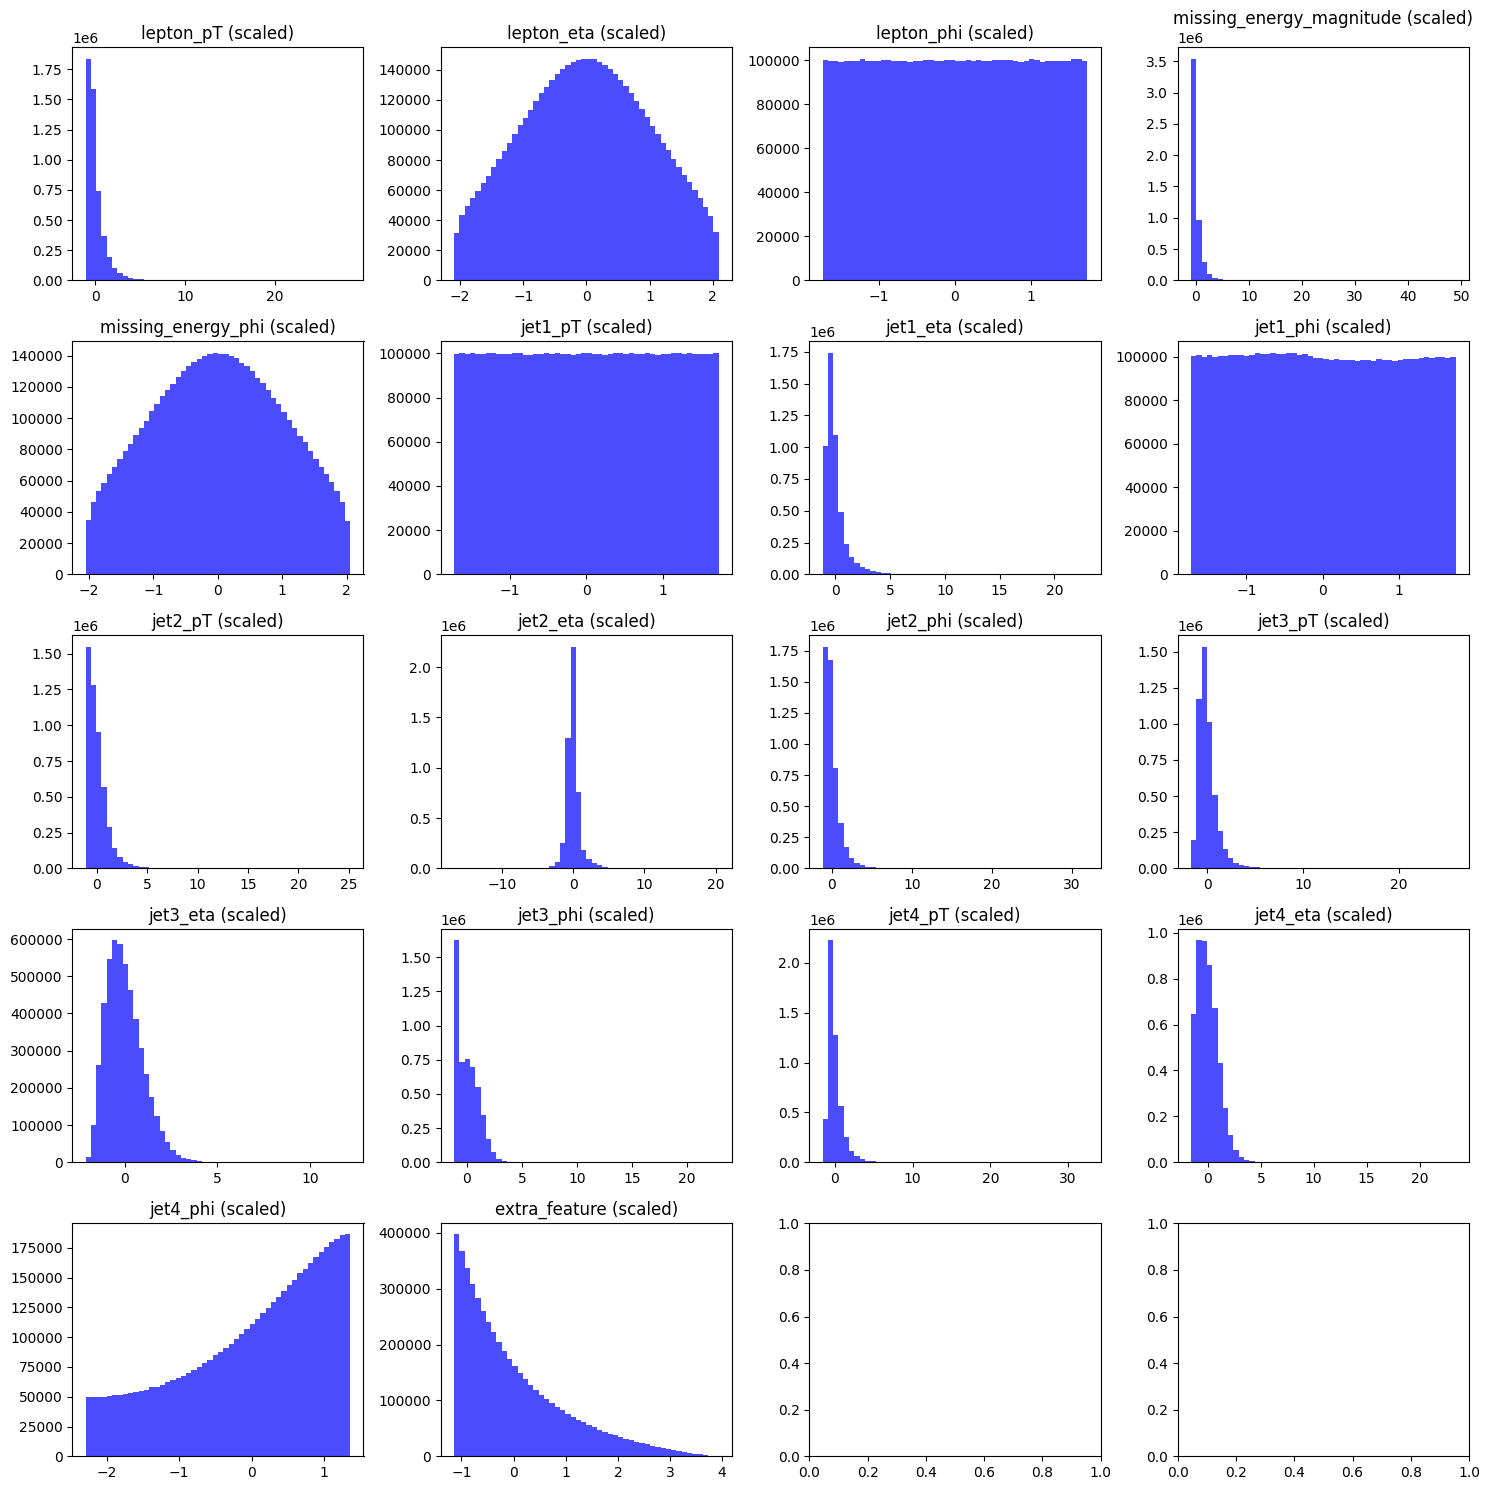

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import kagglehub

# Downloading the latest version of the dataset
path = kagglehub.dataset_download("janus137/supersymmetry-dataset")
dataset_path = "/root/.cache/kagglehub/datasets/janus137/supersymmetry-dataset/versions/1/supersymmetry_dataset.csv"

data = pd.read_csv(dataset_path, header=0)

# Assigning columns
data.columns = [
    'label',
    'lepton_pT', 'lepton_eta', 'lepton_phi',
    'missing_energy_magnitude', 'missing_energy_phi',
    'jet1_pT', 'jet1_eta', 'jet1_phi',
    'jet2_pT', 'jet2_eta', 'jet2_phi',
    'jet3_pT', 'jet3_eta', 'jet3_phi',
    'jet4_pT', 'jet4_eta', 'jet4_phi',
    'extra_feature'
]

print(data.head())
print(data.describe())
print(data.info())

# Define features (X) and labels (y)
X = data.iloc[:, 1:]
y = data.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=10000, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Visualizing the distributions of all scaled features
fig, axs = plt.subplots(5, 4, figsize=(15, 15))
axs = axs.flatten()

for i, col in enumerate(X_train_scaled_df.columns):
    axs[i].hist(X_train_scaled_df[col], bins=50, color='blue', alpha=0.7)
    axs[i].set_title(f'{col} (scaled)')

plt.tight_layout()
plt.show()

**Binary Classifier:**

[To be updated.]

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pickle

# Define model
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Convert data to tensors
x_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
x_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
xy_train = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
loader = torch.utils.data.DataLoader(xy_train, batch_size=int(len(X_train) / 5), shuffle=True)

# Dictionaries to store losses
train_losses_dict = {}
test_losses_dict = {}

# Training loop for different learning rates
for lr in [0.02, 0.05, 0.1]:
    print(f"Learning Rate: {lr}")

    # Initialize model, loss function, and optimizer
    input_dim = X_train.shape[1]
    net = BinaryClassifier(input_dim)
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    net.train()
    train_losses = []
    test_losses = []

    for epoch in range(10):
        start_time = time.time()

        for x_batch, y_batch in loader:
            y_pred = net(x_batch)
            optimizer.zero_grad()
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())

        net.eval()
        with torch.no_grad():
            y_pred_test = net(x_test_tensor)
            test_loss = loss_fn(y_pred_test, y_test_tensor)
            test_losses.append(test_loss.item())

        end_time = time.time()
        print(f"Epoch {epoch+1:2d} | Time: {end_time - start_time:.1f}s | Train Loss: {loss.item():.1e} | Test Loss: {test_loss.item():.1e}")

    train_losses_dict[lr] = train_losses
    test_losses_dict[lr] = test_losses

with open("loss_data.pkl", "wb") as f:
    pickle.dump({"train": train_losses_dict, "test": test_losses_dict}, f)

print("Loss values saved to loss_data.pkl")
torch.save(net.state_dict(), "binary_classifier.pth")

Learning Rate: 0.02
Epoch  1 | Time: 80.8s | Train Loss: 6.0e-01 | Test Loss: 5.7e-01
Epoch  2 | Time: 80.6s | Train Loss: 4.9e-01 | Test Loss: 4.8e-01
Epoch  3 | Time: 79.9s | Train Loss: 4.8e-01 | Test Loss: 4.7e-01
Epoch  4 | Time: 79.5s | Train Loss: 4.7e-01 | Test Loss: 4.6e-01
Epoch  5 | Time: 81.9s | Train Loss: 4.6e-01 | Test Loss: 4.5e-01
Epoch  6 | Time: 81.9s | Train Loss: 4.6e-01 | Test Loss: 4.5e-01
Epoch  7 | Time: 79.8s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  8 | Time: 80.5s | Train Loss: 4.5e-01 | Test Loss: 4.5e-01
Epoch  9 | Time: 80.2s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Epoch 10 | Time: 81.2s | Train Loss: 4.4e-01 | Test Loss: 4.4e-01
Learning Rate: 0.05
Epoch  1 | Time: 81.2s | Train Loss: 5.4e-01 | Test Loss: 5.0e-01
Epoch  2 | Time: 80.7s | Train Loss: 5.8e-01 | Test Loss: 5.5e-01
Epoch  3 | Time: 85.0s | Train Loss: 4.9e-01 | Test Loss: 4.7e-01
Epoch  4 | Time: 82.4s | Train Loss: 4.8e-01 | Test Loss: 4.7e-01
Epoch  5 | Time: 82.0s | Train Loss:

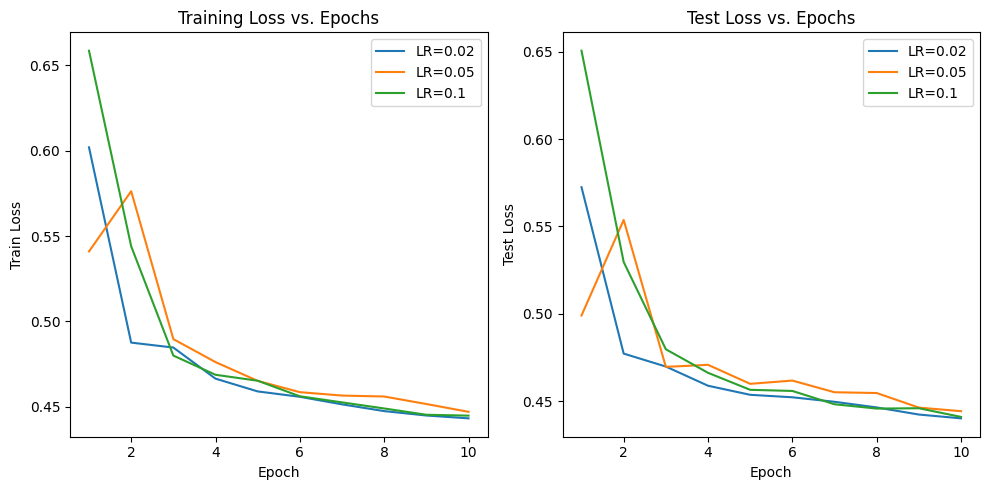

In [3]:
import pickle
import matplotlib.pyplot as plt

with open("loss_data.pkl", "rb") as f:
    loss_data = pickle.load(f)

train_losses_dict = loss_data["train"]
test_losses_dict = loss_data["test"]

plt.figure(figsize=(10, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
for lr, losses in train_losses_dict.items():
    plt.plot(range(1, 11), losses, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()

# Plot Test Loss
plt.subplot(1, 2, 2)
for lr, losses_test in test_losses_dict.items():
    plt.plot(range(1, 11), losses_test, label=f"LR={lr}")
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.title("Test Loss vs. Epochs")
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-10-a72dad66fb36>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("binary_classifier.pth"))


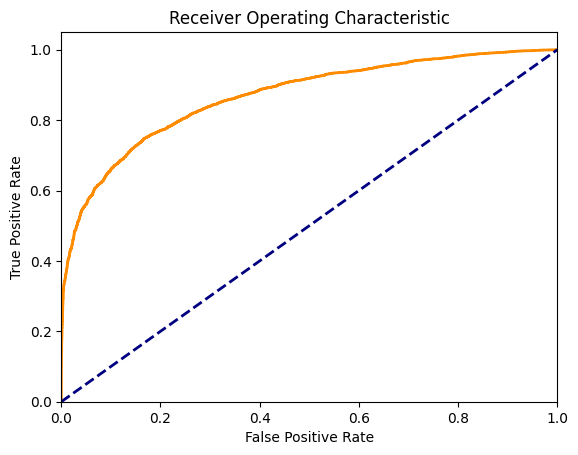

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Load the trained model
net.load_state_dict(torch.load("binary_classifier.pth"))
net.eval()
with torch.no_grad():
    y_pred_test = net(x_test_tensor)

y_pred_probs = y_pred_test

y_pred_probs = y_pred_probs.cpu().numpy()
fpr, tpr, thresholds = roc_curve(y_test_tensor, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.show()

<ipython-input-14-28aa15004eb2>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load("binary_classifier.pth"))


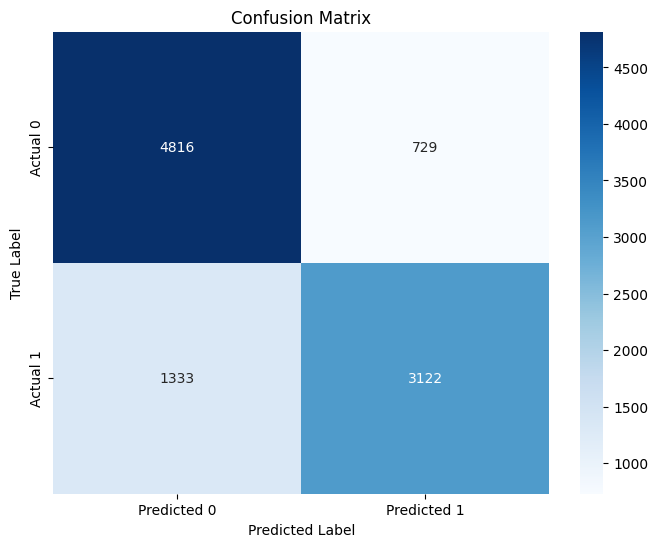

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the trained model
net.load_state_dict(torch.load("binary_classifier.pth"))
net.eval()
with torch.no_grad():
    y_pred_test = net(x_test_tensor)

y_pred_probs = y_pred_test
y_pred_binary = (y_pred_probs > 0.5).float()

y_test_no = y_test_tensor.cpu().numpy()
y_pred_binary_np = y_pred_binary.cpu().numpy()

cm = confusion_matrix(y_test_no, y_pred_binary_np)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels = ['Predicted 0', 'Predicted 1'],
            yticklabels = ['Actual 0', 'Actual 1']
            )
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Autoencoder for Feature Extraction:**

[To be updated.]

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time
import pickle

# Adjusted loss function with mean reduction
def loss_function_MSE(x_hat, x, mu, logvar, β=0.1):
    MSE = nn.functional.mse_loss(x_hat, x, reduction='mean')  # Changed from 'sum' to 'mean'
    KLD = 0.5 * torch.mean(logvar.exp() - logvar - 1 + mu.pow(2))  # Mean instead of sum
    return MSE + β * KLD

# Define the VAE class
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=8): # latent_dim can be adjusted
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 16),
            nn.LeakyReLU()
        )

        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 32),
            nn.LeakyReLU(),
            nn.Linear(32, input_dim),
            nn.Sigmoid() # Using sigmoid for output between 0 and 1 for scaled data
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):

        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

# Hyperparameters
learning_rate = 1e-3
epochs = 10
batch_size = 32  # Reduced batch size for faster updates

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup
input_dim = X_train_scaled_df.shape[1]
model = VAE(input_dim=input_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to tensors and create DataLoader
X_train_tensor = torch.tensor(X_train_scaled_df.values, dtype=torch.float32, device=device)  # Ensure it's on the correct device
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)  # Ensure batch is also on device
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_function_MSE(x_hat, x, mu, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f'Epoch {epoch+1}: Average training loss: {train_loss / len(train_loader):.4f}')  # Adjusted normalization

Epoch 1: Average training loss: 0.7542
Epoch 2: Average training loss: 0.7313
Epoch 3: Average training loss: 0.7206
Epoch 4: Average training loss: 170.2390
Epoch 5: Average training loss: 162.8046
Epoch 6: Average training loss: 2.7064
Epoch 7: Average training loss: 0.7140
Epoch 8: Average training loss: 9048.8749
Epoch 9: Average training loss: 0.7101
Epoch 10: Average training loss: 0.7098


Visualizing the results:

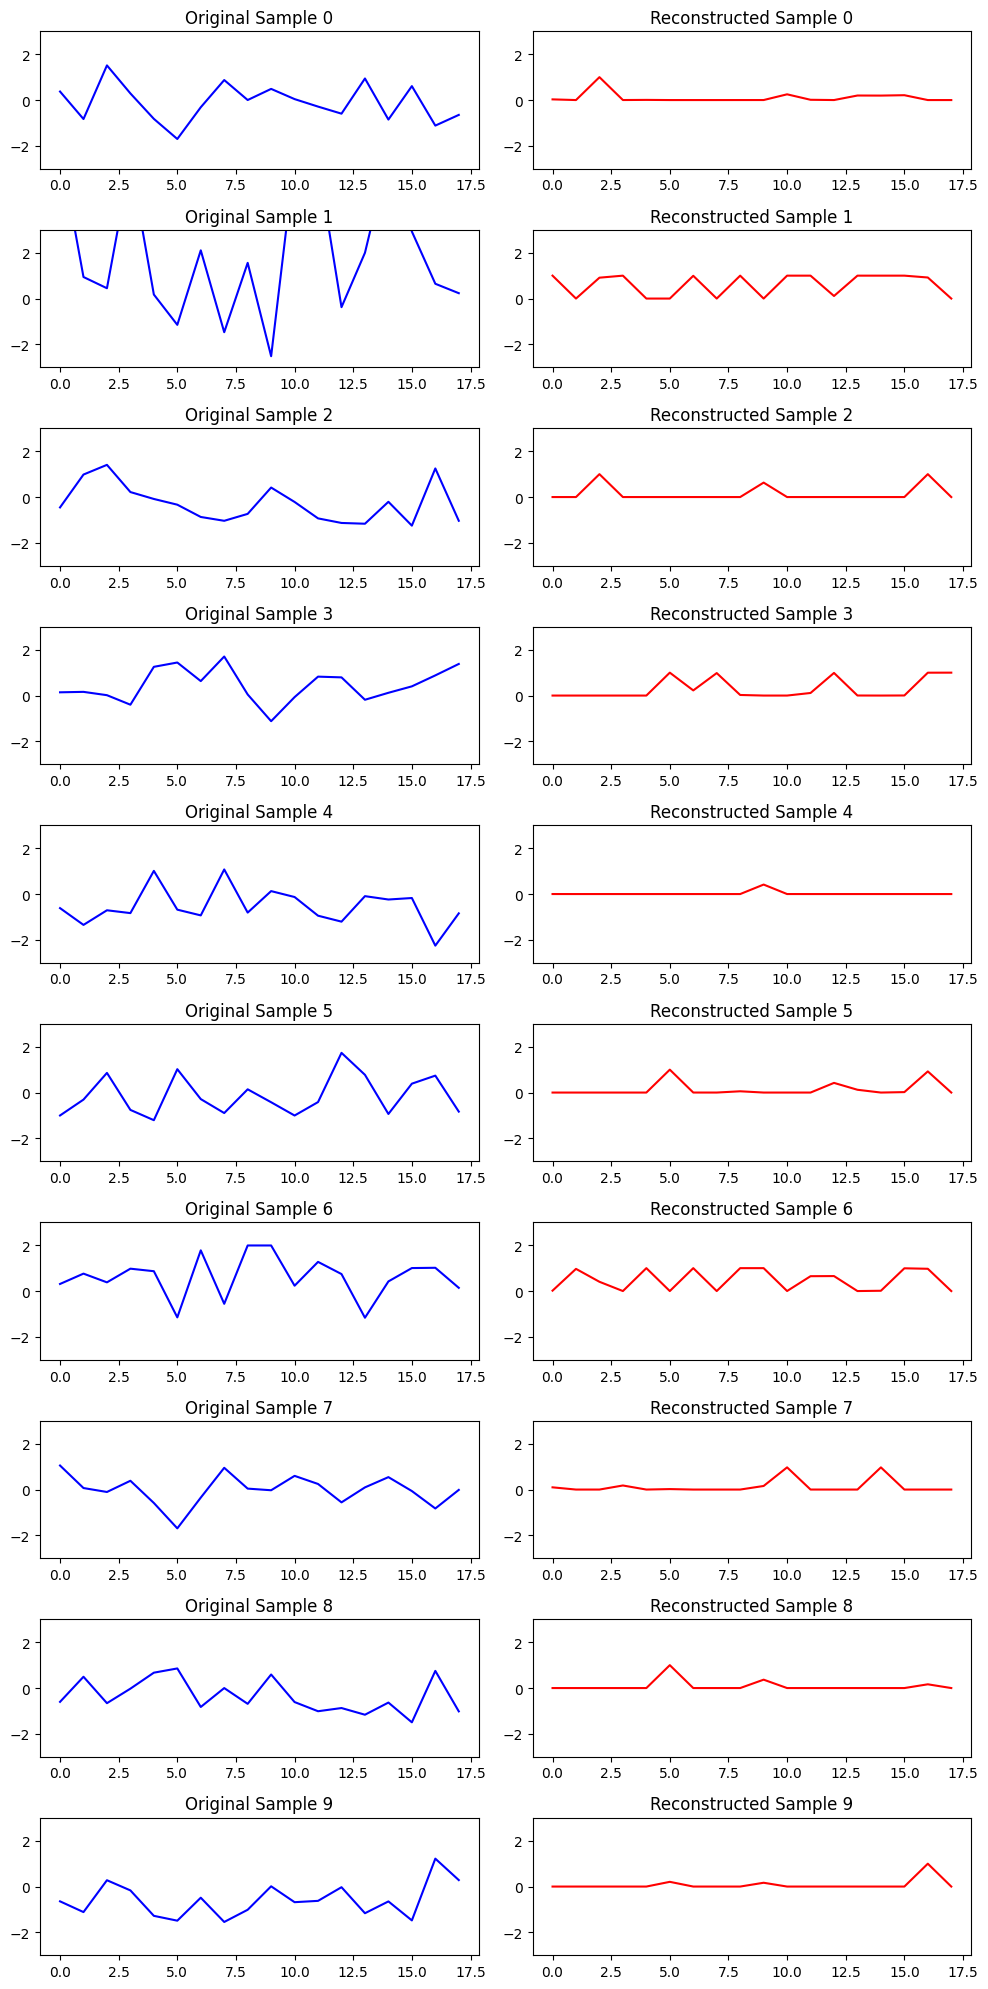

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Select a few samples to visualize
num_samples = 10  # Adjust as needed
x_original = torch.tensor(X_test_scaled[:num_samples]).to(device).float()

# Pass through the VAE
with torch.no_grad():
    x_reconstructed, _, _ = model(x_original)

# Convert back to NumPy for plotting
x_original = x_original.cpu().numpy()
x_reconstructed = x_reconstructed.cpu().numpy()

# Plot original vs reconstructed features
fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 2))

for i in range(num_samples):
    axes[i, 0].plot(x_original[i], label='Original', color='blue')
    axes[i, 0].set_title(f"Original Sample {i}")
    axes[i, 0].set_ylim([-3, 3])  # Adjust based on scaled data

    axes[i, 1].plot(x_reconstructed[i], label='Reconstructed', color='red')
    axes[i, 1].set_title(f"Reconstructed Sample {i}")
    axes[i, 1].set_ylim([-3, 3])

plt.tight_layout()
plt.show()


**Conclusion:**

[Summarize findings and potential improvements]